<a href="https://colab.research.google.com/github/palakbaisla/deforestation_detection/blob/main/Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
5import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from zipfile import ZipFile
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [ ]:
data_path = '/forest_dataset(5000).zip'

with ZipFile(data_path, 'r') as zip:
    zip.extractall()
    print('Done')

Done


In [ ]:
image_dir = '/content/forest_dataset(5000)/images'
mask_dir = '/content/forest_dataset(5000)/masks'

In [ ]:
image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
mask_filenames = sorted([f.replace('sat_', 'mask_') for f in image_filenames])

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32

In [ ]:
train_images, val_images, train_masks, val_masks = train_test_split(
    image_filenames, mask_filenames, test_size=0.2, random_state=42
)

In [ ]:
def load_batch(batch_indices, images, masks, image_dir, mask_dir):
    image_batch = []
    mask_batch = []
    for idx in batch_indices:
        img_path = os.path.join(image_dir, images[idx])
        mask_path = os.path.join(mask_dir, masks[idx])

        # Loading and resizing
        img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        mask = load_img(mask_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode="grayscale")

        # Converting to numpy arrays and normalizing (0-1)
        img = img_to_array(img) / 255.0
        mask = img_to_array(mask) / 255.0

        # Appending in a batch
        image_batch.append(img)
        mask_batch.append(mask)

    return np.array(image_batch), np.array(mask_batch)

In [ ]:
batch_indices = list(range(BATCH_SIZE))  # First batch indices
train_images_batch, train_masks_batch = load_batch(batch_indices, train_images, train_masks, image_dir, mask_dir)

In [ ]:
print("Train images batch shape:", train_images_batch.shape)
print("Train masks batch shape:", train_masks_batch.shape)

Train images batch shape: (32, 256, 256, 3)
Train masks batch shape: (32, 256, 256, 1)


In [ ]:
#combined generator for yielding both image and maks, loads them together
def combined_generator(image_list, mask_list, image_dir, mask_dir, batch_size):
    while True:
        for i in range(0, len(image_list), batch_size):
            batch_indices = list(range(i, min(i + batch_size, len(image_list))))
            images, masks = load_batch(batch_indices, image_list, mask_list, image_dir, mask_dir)
            yield images, masks

# training and validation
train_generator = combined_generator(train_images, train_masks, image_dir, mask_dir, BATCH_SIZE)
val_generator = combined_generator(val_images, val_masks, image_dir, mask_dir, BATCH_SIZE)


In [ ]:
from tensorflow.keras import layers, models

def create_unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Contracting path (Encoder)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive path (Decoder)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)  # For binary segmentation

    # Create the model
    model = models.Model(inputs, outputs)

    return model


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Implementing early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
optimizer = Adam(learning_rate=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

In [ ]:
# Creating the U-Net model
model = create_unet_model(input_size=(256, 256, 3))

# Compilng the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Training the model
model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // BATCH_SIZE,
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_images) // BATCH_SIZE,
    callbacks=[early_stopping]
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.5949 - loss: 0.7175 - val_accuracy: 0.7026 - val_loss: 0.5905
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.7126 - loss: 0.5725 - val_accuracy: 0.7306 - val_loss: 0.5685
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.7389 - loss: 0.5451 - val_accuracy: 0.7425 - val_loss: 0.5562
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.7504 - loss: 0.5284 - val_accuracy: 0.7649 - val_loss: 0.5129
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.7681 - loss: 0.5007 - val_accuracy: 0.7572 - val_loss: 0.5280
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.7714 - loss: 0.4939 - val_accuracy: 0.7540 - val_loss: 0.5479
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.7737 - loss: 0.4924 - val_accuracy: 0.7555 - val_loss: 0.5342
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.7737 - loss: 0.4893 - val_accu

In [ ]:
model.save('forest_segmentation_unet.h5')

In [ ]:
from google.colab import files
files.download('forest_segmentation_unet.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np

def calculate_iou(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    iou = intersection / union
    return iou

def calculate_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice = 2 * intersection / (np.sum(y_true) + np.sum(y_pred))
    return dice

In [ ]:
y_true = np.array([[0, 1, 1], [1, 1, 0], [0, 1, 0]])
y_pred = np.array([[0, 1, 0], [1, 1, 1], [0, 0, 0]])

iou = calculate_iou(y_true, y_pred)
dice = calculate_dice(y_true, y_pred)

print("IoU:", iou)
print("Dice Coefficient:",dice)

IoU: 0.5
Dice Coefficient: 0.6666666666666666


In [ ]:
# Predict on validation data using the validation generator
val_predictions = model.predict(val_generator, steps=len(val_images)//BATCH_SIZE)

31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 574ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


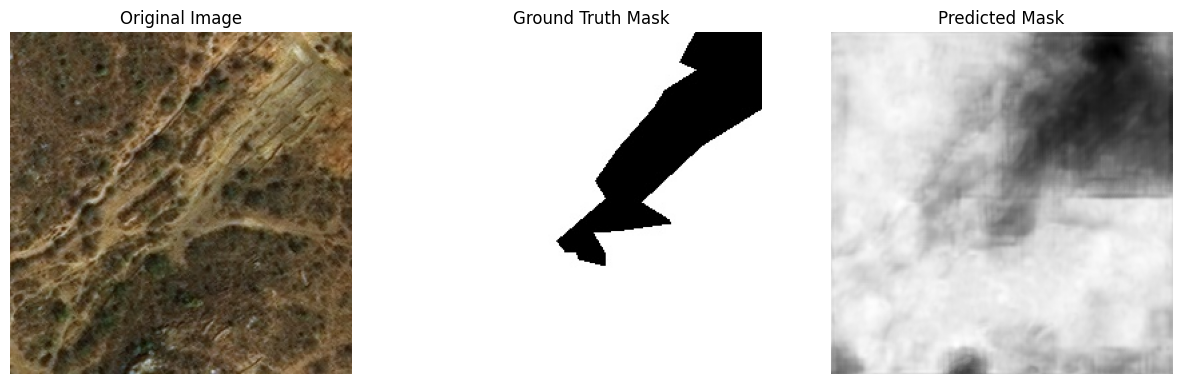

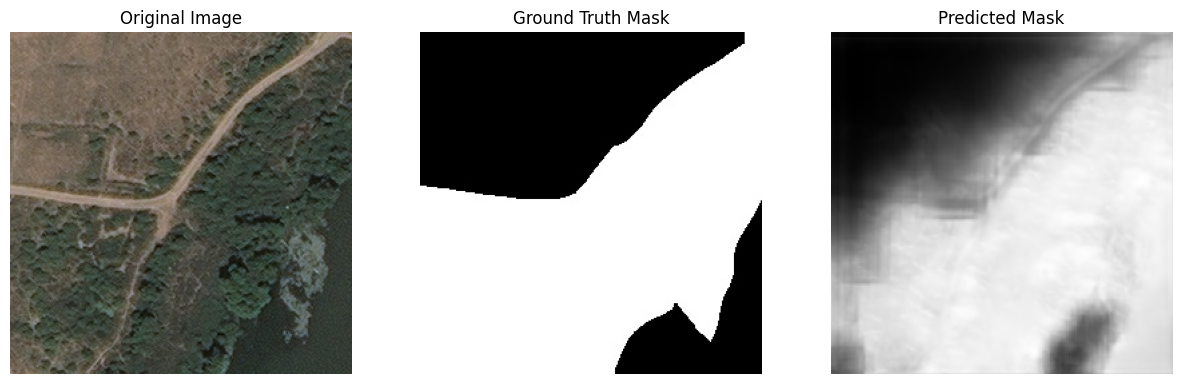

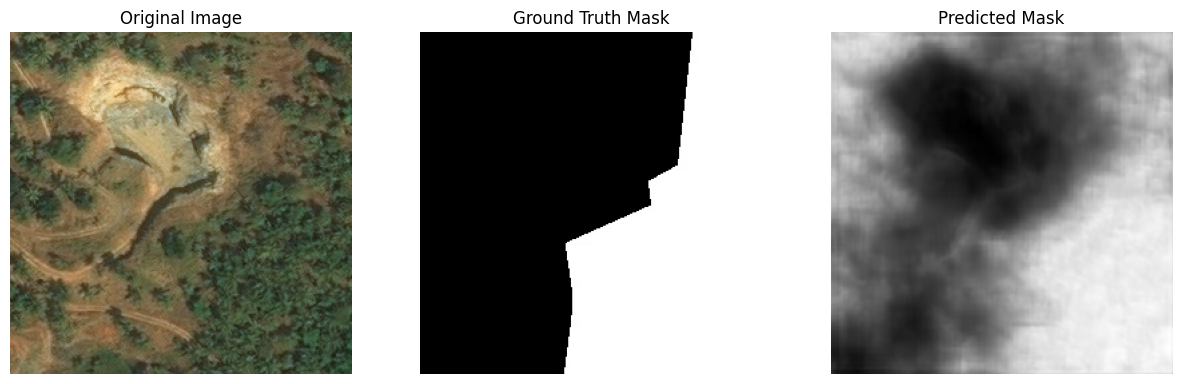

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize a few selected images, ground truth masks, and predictions
def visualize_few_images(images, masks, predictions, indices, image_dir, mask_dir, IMG_SIZE):
    for i in indices:
        # Load the original image
        img_path = os.path.join(image_dir, images[i])
        img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img = img_to_array(img) / 255.0

        # Get the ground truth mask
        mask_path = os.path.join(mask_dir, masks[i])
        mask = load_img(mask_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode="grayscale")
        mask = img_to_array(mask) / 255.0

        # Get the predicted mask
        prediction = predictions[i]

        # Plot the original image, ground truth mask, and predicted mask
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(img)
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        axes[1].imshow(mask.squeeze(), cmap='gray')
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis('off')

        axes[2].imshow(prediction.squeeze(), cmap='gray')
        axes[2].set_title("Predicted Mask")
        axes[2].axis('off')

        plt.show()

# Select specific indices for 2-3 images from validation data (e.g., indices [0, 1, 2])
selected_indices = [0, 1, 2]

# Load those images and masks
images_batch, masks_batch = load_batch(selected_indices, val_images, val_masks, image_dir, mask_dir)

# Predict on these images
predictions_batch = model.predict(images_batch)

# Visualize these selected images, their ground truth, and predictions
visualize_few_images(val_images, val_masks, predictions_batch, selected_indices, image_dir, mask_dir, IMG_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


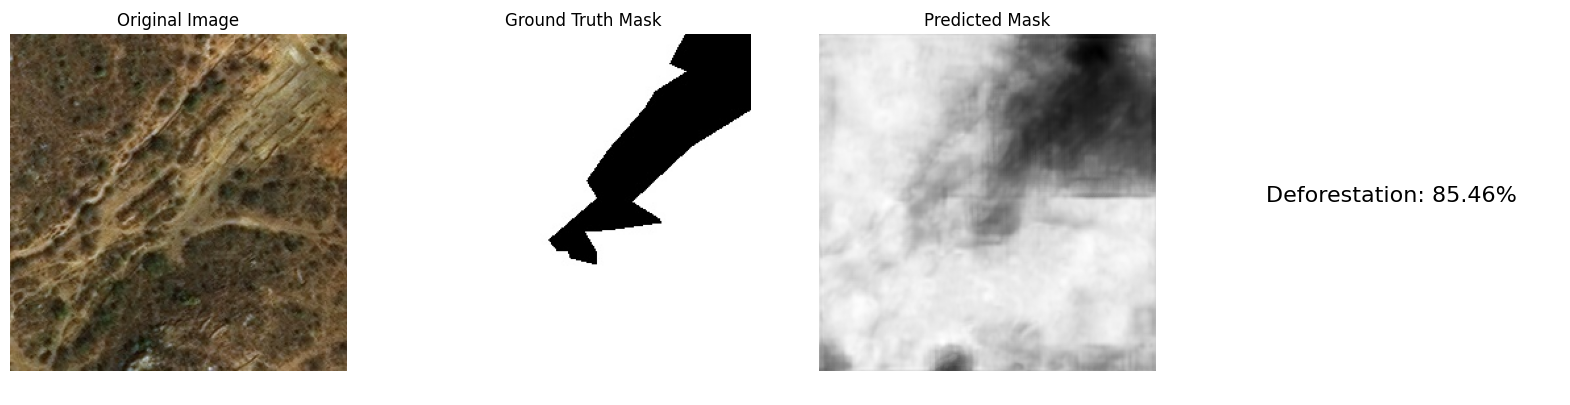

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate deforestation percentage
def calculate_deforestation_percentage(prediction, threshold=0.5):
    # Threshold the prediction to get a binary mask
    binary_mask = (prediction > threshold).astype(np.uint8)

    # Calculate the area of deforestation (number of deforested pixels)
    deforested_area = np.sum(binary_mask)

    # Calculate total pixels in the image
    total_pixels = binary_mask.size

    # Calculate the percentage of deforestation
    deforestation_percentage = (deforested_area / total_pixels) * 100
    return deforestation_percentage

# Function to visualize the image, ground truth mask, and predicted mask
def visualize_deforestation(img, mask, prediction, deforestation_percentage):
    # Plot the original image, ground truth mask, and predicted mask
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(mask.squeeze(), cmap='gray')
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')

    axes[2].imshow(prediction.squeeze(), cmap='gray')
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    # Display the deforestation percentage
    axes[3].text(0.5, 0.5, f"Deforestation: {deforestation_percentage:.2f}%", fontsize=16, ha='center')
    axes[3].axis('off')

    plt.show()

# Example to load an image and make a prediction
image_idx = 0  # Select an image index from the validation set
image_batch, mask_batch = load_batch([image_idx], val_images, val_masks, image_dir, mask_dir)
prediction_batch = model.predict(image_batch)

# Get the prediction for the selected image
prediction = prediction_batch[0]

# Calculate the deforestation percentage
deforestation_percentage = calculate_deforestation_percentage(prediction)

# Visualize the image, ground truth, and prediction with deforestation percentage
visualize_deforestation(image_batch[0], mask_batch[0], prediction, deforestation_percentage)